## Metrics for imbalanced datasets

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle 
import scikitplot as skplt
import seaborn as sns
sns.set_style('whitegrid')

# PyTorch for logistic regression
import torch 
import torch.nn as nn

In [2]:
def get_inbalance_data(mnist, neg_class=0, pos_class=6, pos_rate=0.05):
    n_train = int(60e3)
    n_test = int(10e3)
    indices = np.arange(len(mnist.data))
    train_idx = np.arange(0, n_train)
    test_idx = np.arange(n_train+1, n_train+n_test)

    x_train, y_train = mnist.data[train_idx], mnist.target[train_idx]
    x_test, y_test = mnist.data[test_idx], mnist.target[test_idx]

    zero_indices_train = np.argwhere(y_train == neg_class).flatten()
    ones_indices_train = np.argwhere(y_train == pos_class).flatten()
    ones_indices_train = ones_indices_train[:int(len(ones_indices_train) * pos_rate)]

    zero_indices_test = np.argwhere(y_test == neg_class).flatten()
    ones_indices_test = np.argwhere(y_test == pos_class).flatten()
    ones_indices_test = ones_indices_test[:int(len(ones_indices_test) * pos_rate)]

    print("Train: ", len(zero_indices_train), len(ones_indices_train))
    print("Test: ", len(zero_indices_test), len(ones_indices_test))

    # Select only "0" and "1" classes
    x_train = x_train[np.hstack([ones_indices_train, zero_indices_train])]
    y_train = y_train[np.hstack([ones_indices_train, zero_indices_train])]
    x_test = x_test[np.hstack([ones_indices_test, zero_indices_test])]
    y_test = y_test[np.hstack([ones_indices_test, zero_indices_test])]

    y_train[y_train == neg_class] = 0
    y_train[y_train == pos_class] = 1
    y_test[y_test == neg_class] = 0
    y_test[y_test == pos_class] = 1
    
    return (x_train, y_train), (x_test, y_test)

In [3]:
def show_metrics(y_true, y_score):
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    print("True positive: ", tp)
    print("False positive: ", fp)
    print("True negative: ", tn)
    print("False negative: ", fn)

    print("True positive rate (recall): ", tpr)
    print("False positive rate: ", fpr)
    print("Precision: ", precision)
    print("True negative rate: ", tnr)
    print("F1: ", f1)
    print("ROC-AUC: ", auc)
    print("MCC: ", mcc)

    
def show_metrics_sklearn(y_true, y_pred):
    print("Precision: ", metrics.precision_score(y_true, y_pred))
    print("Recall: ", metrics.recall_score(y_true, y_pred))
    print("F1 score: ", metrics.f1_score(y_true, y_pred))
    print("Mean accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("AUC: ", metrics.roc_auc_score(y_true, y_pred))
    print("mcc: ", metrics.matthews_corrcoef(y_true, y_pred))

In [4]:
def roc_auc_score(y_true, y_pred):
    unique_vals = list(np.sort(np.unique(y_pred))) + [1]
    area_under_curve = 0
    fpr_points, tpr_points = [], []
    for i, th in enumerate(unique_vals):
        y_pred_th = np.zeros(len(y_pred))
        y_pred_th[y_pred >= th] = 1.0
        
        tp = np.sum(y_true * y_pred_th)
        fp = np.sum((y_true == 0) * y_pred_th)
        tn = np.sum((y_true==0) * (y_pred_th==0))
        fn = np.sum(y_true * (y_pred_th==0))
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        fpr_points.append(fpr)
        tpr_points.append(tpr)
        
        if i > 0:
            area_under_curve += (fpr_prev - fpr) * tpr
        fpr_prev = fpr
        
    plt.figure(figsize=(5, 5), dpi=100)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    sns.lineplot(fpr_points, tpr_points)
    plt.show()
        
    return area_under_curve

### Logistic regression

In [5]:
class LogReg(nn.Module):
    def __init__(self, in_dim):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        y_pred = self.sigmoid(self.linear(x))
        return y_pred

    
def DataLoader(x, y, batch_size, shuffle=True):
    def wrap():
        inds = np.arange(n)
        if shuffle:
            np.random.shuffle(inds)
        for bi in range(n//batch_size):
            batch_x = x[inds[bi*batch_size:(bi+1)*batch_size]]
            batch_y = y[inds[bi*batch_size:(bi+1)*batch_size]]
            yield (batch_x, batch_y)

    n = len(x)
    return wrap()

In [6]:
input_size = 784
num_classes = 2
num_epochs = 1
batch_size = 32
learning_rate = 1e-3

mnist = fetch_mldata('MNIST original', data_home='~/dl/data/')
(x_train, y_train), (x_test, y_test) = get_inbalance_data(mnist, pos_rate=0.3)
# Data scaling
x_train = 1 - (x_train / 255.)
x_test = 1 - (x_test / 255.)

model = LogReg(784)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
# Train
for epoch in range(num_epochs):
    batch_i = 0
    train_loader = DataLoader(x_train, y_train, 32)
    for x, y in train_loader:
        batch_i += 1
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_i % 50 == 0:
            print('Epoch {}, Step {}, Loss: {:.4f}'.format(epoch+1, batch_i+1, loss.item()))

            
# Validate
test_loader = DataLoader(x_test ,y_test, len(x_test), shuffle=False)
with torch.no_grad():
    correct = 0
    total = 0
    for x, y in test_loader:
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        outputs = model(x)
        predicted = (outputs >= 0.5).float().squeeze()
        total += y.size(0)
        correct += torch.eq(predicted, y).sum()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Train:  5923 1775
Test:  979 287
Epoch 1, Step 51, Loss: 0.5266
Epoch 1, Step 101, Loss: 0.5140
Epoch 1, Step 151, Loss: 0.4788
Epoch 1, Step 201, Loss: 0.5007
Accuracy of the network on the test images: 77 %


/home/igor/miniconda3/envs/pt/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/igor/miniconda3/envs/pt/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/igor/miniconda3/envs/pt/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [7]:
y_pred = outputs.numpy().squeeze()

show_metrics_sklearn(y_test, (y_pred >= 0.5).astype(np.int))

Precision:  1.0
Recall:  0.017421602787456445
F1 score:  0.03424657534246575
Mean accuracy:  0.7772511848341233
AUC:  0.5087108013937283
mcc:  0.11629950236238414


### ROC-AUC

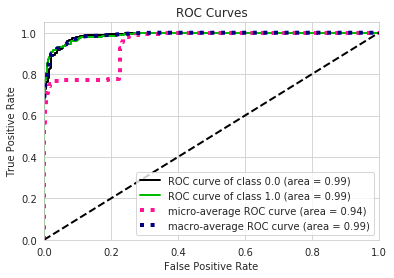

In [8]:
y_pred_ = np.zeros((y_pred.shape[0], 2))
for i in range(len(y_pred)):
    y_pred_[i, 0] = 1-y_pred[i]
    y_pred_[i, 1] = y_pred[i]

skplt.metrics.plot_roc(y_test, y_pred_)

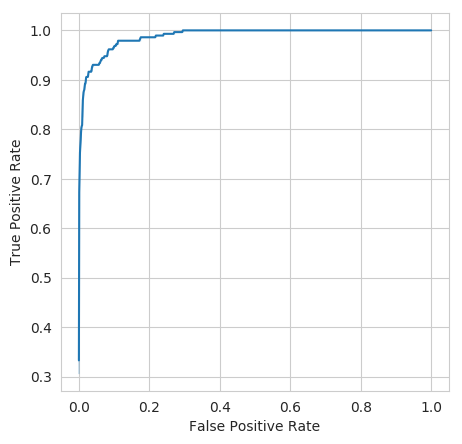

0.9886501549971014

In [9]:
roc_auc_score(y_test, y_pred)